# Disease-Gene Association Prediction

Disease-gene association prediction can be formulated as a link prediction problem on a graph. I use the PyTorch Geometric (PyG) package to perform link prediction using a graph neural network.

Adapted from the PyTorch Geometric [link prediction example](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py).

In [2]:
import numpy as np
import networkx as nx
import pandas as pd

import random

from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, f1_score

import torch
import torch_geometric
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.utils import train_test_split_edges, from_networkx, negative_sampling, remove_self_loops,\
    add_self_loops, to_undirected, dropout_adj

from matplotlib import pyplot as plt
import seaborn as sns

## Data loading

In [3]:
G_disease_gene = nx.read_gpickle("data/disease_gene_graph.pkl")
G_disease = nx.read_gpickle("data/disease_graph.pkl")
G_gene = nx.read_gpickle("data/gene_graph.pkl")

In [4]:
def my_from_networkx(G):
    """
    Edited version so that the node labels aren't changed.
    
    Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    # G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.tensor(list(G.edges)).t().contiguous()

    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
            data[key] = [value] if i == 0 else data[key] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[key] = [value] if i == 0 else data[key] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

In [5]:
def edges_in_G(G, edge_index):
    """
    Checks if each of the edges in an edge index are in the graph G
    Returns a tuple where the first element is the number of edges found in G,
        and the second element is the number of edges that were not found in G.
    """
    G = nx.to_directed(G)
    in_G = not_in_G = 0
    for n1, n2 in zip(edge_index.numpy()[0], edge_index.numpy()[1]):
        if (n1, n2) in G.edges():
            in_G += 1
        else:
            not_in_G += 1

    return(in_G, not_in_G)

In [6]:
disease_gene_data = my_from_networkx(G_disease_gene)
disease_gene_edge_index = disease_gene_data.edge_index
edges_in_G(G_disease_gene, disease_gene_data.edge_index) # make sure node labels in edge_index are the same as in G

(42714, 0)

In [7]:
disease_data = my_from_networkx(G_disease)
edges_in_G(G_disease, disease_data.edge_index) # make sure node labels in edge_index are the same as in G

(163, 0)

In [8]:
gene_data = my_from_networkx(G_gene)
edges_in_G(G_gene, gene_data.edge_index) # make sure node labels in edge_index are the same as in G

(263018, 0)

## Train test split
Only the disease-gene edges are split, because these are the edges we are predicting. The other edges (disease-disease and gene-gene) are basically features that are used in every training and prediction.

In [9]:
def my_train_test_split_edges(data, disease_nodes, gene_nodes, val_ratio=0.05, test_ratio=0.1):
    """
    Adapted from the PyTorch Geometric version here:
    https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/train_test_split_edges.html#train_test_split_edges
    This version is specific to my dataset, and differs in that it only samples negative 
    and positive edges from a subset of all edges: the disease-gene edges.
    
    Splits the edges of a torch_geometric.data.Data object
    into positive and negative train/val/test edges, and adds attributes of
    `train_pos_edge_index`, `train_neg_adj_mask`, `val_pos_edge_index`,
    `val_neg_edge_index`, `test_pos_edge_index`, and `test_neg_edge_index`
    to `data`.

    Args:
        data (Data): The data object.
        edge_set: a set of the relevant edges in the graph
        disease_nodes: a list of all disease node ids
        gene_nodes: a list of all gene node ids
        val_ratio (float, optional): The ratio of positive validation
            edges. (default: :obj:`0.05`)
        test_ratio (float, optional): The ratio of positive test
            edges. (default: :obj:`0.1`)
    """

    num_nodes = data.num_nodes
    row, col = data.edge_index
    data.edge_index = None

    # Return upper triangular portion.
    mask = row < col
    row, col = row[mask], col[mask]

    n_v = int(np.floor(val_ratio * row.size(0)))
    n_t = int(np.floor(test_ratio * row.size(0)))

    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]

    r, c = row[:n_v], col[:n_v]
    data.val_pos_edge_index = torch.stack([r, c], dim=0)
    r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
    data.test_pos_edge_index = torch.stack([r, c], dim=0)

    r, c = row[n_v + n_t:], col[n_v + n_t:]
    data.train_pos_edge_index = torch.stack([r, c], dim=0)
    data.train_pos_edge_index = to_undirected(data.train_pos_edge_index)

    # Negative edges. only sample negative edges from disease -> gene space.
    neg_adj_mask = torch.ones(len(disease_nodes), len(gene_nodes)+len(disease_nodes), dtype=torch.uint8).to(torch.bool)
    neg_adj_mask[row, col] = 0 # remove positive edges
    neg_adj_mask[0:len(disease_nodes), 0:len(disease_nodes)] = 0 # remove possible disease-disease links (gene-gene already not present)

    neg_row, neg_col = neg_adj_mask.nonzero().t()
    perm = random.sample(range(neg_row.size(0)), min(n_v + n_t, neg_row.size(0)))
    perm = torch.tensor(perm)
    perm = perm.to(torch.long)
    neg_row, neg_col = neg_row[perm], neg_col[perm]

    neg_adj_mask[neg_row, neg_col] = 0
    data.train_neg_adj_mask = neg_adj_mask

    row, col = neg_row[:n_v], neg_col[:n_v]
    data.val_neg_edge_index = torch.stack([row, col], dim=0)

    row, col = neg_row[n_v:n_v + n_t], neg_col[n_v:n_v + n_t]
    data.test_neg_edge_index = torch.stack([row, col], dim=0)

    return data

In [10]:
# load the disease and gene dfs
diseases = pd.read_pickle("data/diseases_df.pkl")
genes = pd.read_pickle("data/genes_df.pkl")

# get lists of the disease node ids and gene node ids
disease_nodes = diseases["disease_node_id"].values
gene_nodes = genes["gene_node_id"].values

In [11]:
# train test split
disease_gene_data.train_mask = disease_gene_data.val_mask = disease_gene_data.test_mask = disease_gene_data.y = None
disease_gene_data = my_train_test_split_edges(disease_gene_data, disease_nodes, gene_nodes)

## Graph network definition

Graph networks are similar to convolutional neural networks, except that they convolve over a graph rather than an image. Multiple graph convolutional layers are stacked on top of each other to pull in info from further away in the graph.

The diseases and genes have different numbers of features so they each get there own layer at the start of the network (bringing them to the same latent size), after which they are merged.

Another note: no matter what edge index is passed into the model, the disease-gene training edge index is used to propogate features between diseases and genes, and every disease-disease edge and gene-gene edge are used to propogate features as well. The edge index that is passed into the model is only used to select which of the node embeddings are relevant for computing the specified output. I mention this just to help clarify which edges are used when and where.

In [12]:
num_disease_features = disease_data.num_features # 1124
num_gene_features = gene_data.num_features # 8769

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.disease_conv = GCNConv(num_disease_features, 128)
        
        self.gene_conv = GCNConv(num_gene_features, 128)
        
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 32)

    def forward(self, pos_edge_index, neg_edge_index=[], predict=False):
        x_disease = F.relu(self.disease_conv(disease_data.x, disease_data.edge_index))
        
        x_gene = F.relu(self.gene_conv(gene_data.x, disease_data.edge_index))

        x = torch.cat((x_disease, x_gene), dim=0) # stack the two latent feature matrices
        
        x = F.relu(self.conv2(x, disease_gene_data.train_pos_edge_index)) # propogate features on training edges
        x = self.conv3(x, disease_gene_data.train_pos_edge_index) # propogate features on training edges

        # if we are predicting, then we don't know whether the edges are positive or negative, so they
        # are all passed in under the pos_edge_index (even though they might be negative).
        if predict:
            total_edge_index = pos_edge_index
        else:
            assert len(neg_edge_index) != 0, "training requires negative edges"
            total_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenates pos and neg edges
        
        x_j = torch.index_select(x, 0, total_edge_index[0]) # set of node encodings at start of edges
        x_i = torch.index_select(x, 0, total_edge_index[1]) # set of node encodings at end of edges
        return torch.einsum("ef,ef->e", x_i, x_j) # row wise dot product

## Utility functions

In [13]:
def get_link_labels(pos_edge_index, neg_edge_index):
    link_labels = torch.zeros(pos_edge_index.size(1) +
                              neg_edge_index.size(1)).float()
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [14]:
def random_neg_edge_sample(disease_gene_edge_index, disease_nodes, gene_nodes, num_samples, print_adj_mask=False):
    """
    adapted from Pytorch Geometric's train_test_split_edges function
    """
    row, col = disease_gene_edge_index # the positive edges
    mask = row < col # mask for edges in the upper triangle (those in the lower triangle are duplicates)
    row, col = row[mask], col[mask]
    
    neg_adj_mask = torch.ones(len(disease_nodes), len(gene_nodes)+len(disease_nodes), dtype=torch.uint8).to(torch.bool)
    neg_adj_mask[row, col] = 0 # remove positive edges
    neg_adj_mask[0:len(disease_nodes), 0:len(disease_nodes)] = 0 # remove possible disease-disease links (gene-gene already not present)
    
    if print_adj_mask:
        neg_adj_mask = neg_adj_mask[:, 519:]
        plt.matshow(neg_adj_mask)
        plt.xlabel("genes")
        plt.ylabel("diseases")
        plt.title("Disease vs Gene Space", pad=30)
        return

    neg_row, neg_col = neg_adj_mask.nonzero().t() # COO format
    perm = random.sample(range(neg_row.size(0)), num_samples) # get random indices
    perm = torch.tensor(perm)
    perm = perm.to(torch.long)
    neg_row, neg_col = neg_row[perm], neg_col[perm] # get the row and cols from random indices
    neg_edge_index = torch.stack((neg_row, neg_col))
    
    return neg_edge_index

**Negative Sampling**

Negative edge sampling is the process of selecting *negative* edges: hypothetical edges which *could* have been in the actual graph, but are not. Why? We need negative edges because we need to make sure our model doesn't misclassify them as positive edges.

Below is the space from which negative edges are sampled. Yellow shows negative edges, while positive edges (edges that are actually in the disease gene graph) are shown in purple. The purple ones are off limits for negative sampling.

The trend in the positive edges (purple, diagonal from top left to bottom right) is an artifact from how the genes are labeled, and has no effect on the random sampling of the negative (yellow) edges.

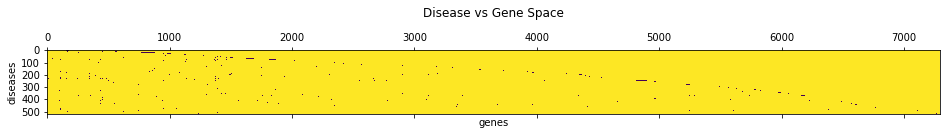

In [15]:
random_neg_edge_sample(disease_gene_edge_index, disease_nodes, gene_nodes, 10, print_adj_mask=True)

## Training and testing functions
TODO: more functional style.

In [16]:
def train():
    """
    Executes a single training cycle (epoch)
    """
    model.train()
    optimizer.zero_grad()

    pos_edge_index = disease_gene_data.train_pos_edge_index
    pos_edge_index = dropout_adj(pos_edge_index, p=.3)[0] # randomly dropout some edges
    
    # random negative edge sample
    neg_edge_index = random_neg_edge_sample(disease_gene_edge_index, disease_nodes,gene_nodes, pos_edge_index.size(1))

    link_logits = model(pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(pos_edge_index, neg_edge_index)

    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss

In [17]:
def test(testing_set="val"):
    """
    Tests the model on the specified data set ("val" or "test"), returning the F1 score
    """
    model.eval()
    
    pos_edge_index, neg_edge_index = [index for _, index in\
                                      disease_gene_data("{}_pos_edge_index".format(testing_set), 
                                                        "{}_neg_edge_index".format(testing_set))]
    
    link_probs = torch.sigmoid(model(pos_edge_index, neg_edge_index))
    link_labels = get_link_labels(pos_edge_index, neg_edge_index)
    link_probs = link_probs.detach().numpy()
    link_labels = link_labels.detach().numpy()
    
    link_preds = (link_probs > .5).astype(int)
    
    return f1_score(link_labels, link_preds)

In [18]:
def predict(edge_index):
    """
    Makes predictions on a set of edges
    """
    model.eval()
    
    link_probs = torch.sigmoid(model(edge_index, predict=True))
    link_probs = link_probs.detach().numpy()
    link_preds = (link_probs > .5).astype(int)
    return link_preds

## Train the model

In [19]:
model = Net()
optimizer = torch.optim.Adam(params=model.parameters())

In [20]:
val_f1s = []
for epoch in range(1, 5):
    train_loss = train()
    val_f1 = test()
    val_f1s.append(val_f1)
    
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val F1: {:.4f}'
    print(log.format(epoch, train_loss, val_f1))

Epoch: 001, Loss: 0.6909, Val F1: 0.6667
Epoch: 002, Loss: 0.6862, Val F1: 0.6667
Epoch: 003, Loss: 0.6791, Val F1: 0.6667
Epoch: 004, Loss: 0.6697, Val F1: 0.6667


### Visualizing model output

In [21]:
print("F1 score:", test("test"))

F1 score: 0.6666666666666666


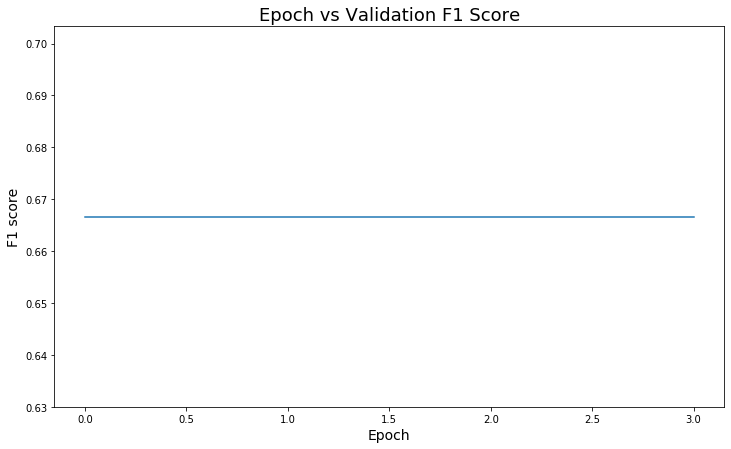

In [22]:
plt.figure(figsize=(12, 7))
plt.plot(val_f1s)
plt.title("Epoch vs Validation F1 Score", fontsize=18)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("F1 score", fontsize=14);
# plt.savefig("Epoch vs F1.png", dpi=200)

In [23]:
# confusion matrix
to_test = torch.cat([disease_gene_data.test_pos_edge_index, disease_gene_data.test_neg_edge_index], dim=-1)
labels = [1 for idx in range(len(disease_gene_data.test_pos_edge_index[0]))]\
       + [0 for idx in range(len(disease_gene_data.test_neg_edge_index[0]))]

preds = predict(to_test)
confusion_matrix(labels, preds)

array([[   0, 2135],
       [   0, 2135]])

In [24]:
# seperate outputs by true class 
link_probs = torch.sigmoid(model(disease_gene_data.test_pos_edge_index, disease_gene_data.test_neg_edge_index))
link_probs = link_probs.detach().numpy()

pos_link_probs = link_probs[:len(disease_gene_data.test_pos_edge_index[0])]
neg_link_probs = link_probs[len(disease_gene_data.test_pos_edge_index[0]):]

probs = np.array([pos_link_probs, neg_link_probs]).T

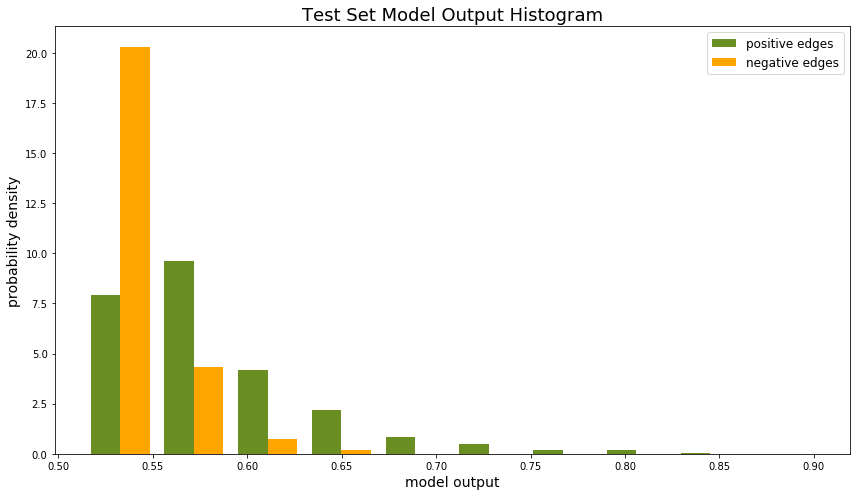

In [25]:
plt.figure(figsize=(12,7))
plt.hist(probs, density=True, color=["olivedrab", "orange"], label=["positive edges", "negative edges"])
plt.title("Test Set Model Output Histogram", fontsize=18)
plt.xlabel("model output", fontsize=14)
plt.ylabel("probability density", fontsize=14)
plt.legend(fontsize=12);
plt.tight_layout()
# plt.savefig("test_prob_hist.png", dpi=200)

# Analysis

For the most part, the model learns to output high probabilities for positive edges and low probabilities for negative edges. However it has some trouble with false negatives (green bar on the far left of the histogram above). It tends to predict very confidently that a small subset of the positive edges are actually negative. This is a problem in the context of searching for new drugs, because if researchers ignore some potentially positive associations between genes and diseases, then those genes will never be targeted for further study. This is a good starting point for future work to improve the model.

This proof-of-concept model performs surprising well for using just clinical description TF-IDF word vectors as features. Adding more features could significantly improve the predictions. Some ideas for other features:
- disease ontology
- gene expression data